ACTIVE RM_IDS ANALYSIS

Total rm_ids to predict: 203

[1] ACTIVITY BREAKDOWN
--------------------------------------------------------------------------------
activity_category
Very Recent (< 3 months)     41
Recent (3-12 months)         19
Older (1-2 years)            12
Very Old (> 2 years)        131
Name: count, dtype: int64

[2] STATISTICS
--------------------------------------------------------------------------------
Min days since last receival: 12
Max days since last receival: 7496
Mean days since last receival: 2844
Median days since last receival: 2365

rm_ids with deliveries in 2024: 61
Percentage of prediction rm_ids active in 2024: 29.6%

rm_ids with deliveries since Oct 2024: 41
Percentage of prediction rm_ids active since Oct 2024: 20.2%

[3] FUTURE PURCHASE ORDERS ANALYSIS
--------------------------------------------------------------------------------
Purchase orders with delivery_date >= 2025-01-01: 148
Unique product_ids in future POs: 17
Date range of future POs: 20

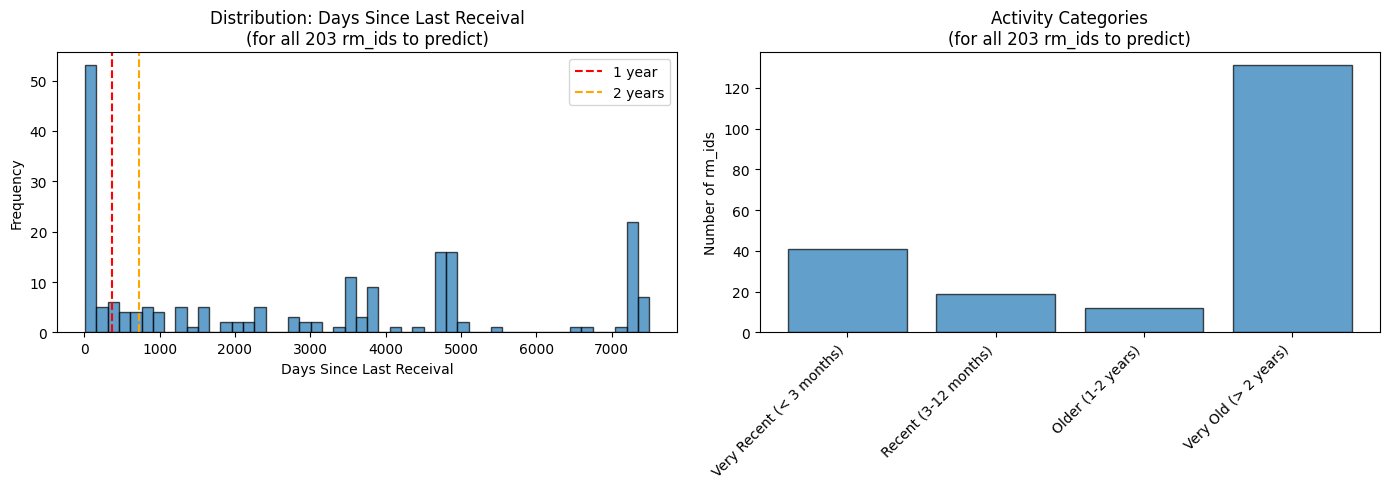

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
receivals = pd.read_csv('./Project_materials/data/kernel/receivals.csv')
purchase_orders = pd.read_csv('./Project_materials/data/kernel/purchase_orders.csv')
prediction_mapping = pd.read_csv('./Project_materials/data/prediction_mapping.csv')

# Convert dates
receivals['date_arrival'] = pd.to_datetime(receivals['date_arrival'], utc=True).dt.tz_localize(None)
purchase_orders['delivery_date'] = pd.to_datetime(purchase_orders['delivery_date'], utc=True).dt.tz_localize(None)

prediction_mapping['forecast_start_date'] = pd.to_datetime(prediction_mapping['forecast_start_date'])
prediction_mapping['forecast_end_date'] = pd.to_datetime(prediction_mapping['forecast_end_date'])

print("="*80)
print("ACTIVE RM_IDS ANALYSIS")
print("="*80)

# Get prediction rm_ids
pred_rm_ids = prediction_mapping['rm_id'].unique()
print(f"\nTotal rm_ids to predict: {len(pred_rm_ids)}")

# For each rm_id, find the last receival date
rm_last_dates = receivals.groupby('rm_id')['date_arrival'].max().reset_index()
rm_last_dates.columns = ['rm_id', 'last_receival_date']

# Add this info to prediction rm_ids
pred_rm_summary = pd.DataFrame({'rm_id': pred_rm_ids})
pred_rm_summary = pred_rm_summary.merge(rm_last_dates, on='rm_id', how='left')

# Calculate days since last receival (as of 2025-01-01)
forecast_start = pd.to_datetime('2025-01-01')
pred_rm_summary['days_since_last_receival'] = (forecast_start - pred_rm_summary['last_receival_date']).dt.days

# Categorize by activity
pred_rm_summary['activity_category'] = pd.cut(
    pred_rm_summary['days_since_last_receival'],
    bins=[-np.inf, 90, 365, 730, np.inf],
    labels=['Very Recent (< 3 months)', 'Recent (3-12 months)', 'Older (1-2 years)', 'Very Old (> 2 years)']
)

print("\n[1] ACTIVITY BREAKDOWN")
print("-"*80)
print(pred_rm_summary['activity_category'].value_counts().sort_index())

print("\n[2] STATISTICS")
print("-"*80)
print(f"Min days since last receival: {pred_rm_summary['days_since_last_receival'].min():.0f}")
print(f"Max days since last receival: {pred_rm_summary['days_since_last_receival'].max():.0f}")
print(f"Mean days since last receival: {pred_rm_summary['days_since_last_receival'].mean():.0f}")
print(f"Median days since last receival: {pred_rm_summary['days_since_last_receival'].median():.0f}")

# Check how many have deliveries in 2024
receivals['year'] = receivals['date_arrival'].dt.year
rm_2024 = receivals[receivals['year'] == 2024]['rm_id'].unique()
print(f"\nrm_ids with deliveries in 2024: {len(rm_2024)}")
print(f"Percentage of prediction rm_ids active in 2024: {len([r for r in pred_rm_ids if r in rm_2024]) / len(pred_rm_ids) * 100:.1f}%")

# Check recent activity (last 3 months of 2024)
recent_cutoff = pd.to_datetime('2024-10-01')
rm_recent = receivals[receivals['date_arrival'] >= recent_cutoff]['rm_id'].unique()
print(f"\nrm_ids with deliveries since Oct 2024: {len(rm_recent)}")
print(f"Percentage of prediction rm_ids active since Oct 2024: {len([r for r in pred_rm_ids if r in rm_recent]) / len(pred_rm_ids) * 100:.1f}%")

print("\n[3] FUTURE PURCHASE ORDERS ANALYSIS")
print("-"*80)
# Check if there are purchase orders with future delivery dates
future_pos = purchase_orders[purchase_orders['delivery_date'] >= forecast_start].copy()
print(f"Purchase orders with delivery_date >= 2025-01-01: {len(future_pos)}")
print(f"Unique product_ids in future POs: {future_pos['product_id'].nunique()}")
print(f"Date range of future POs: {future_pos['delivery_date'].min()} to {future_pos['delivery_date'].max()}")

# Check status of future POs
print("\nStatus distribution of future POs:")
print(future_pos['status'].value_counts())

# Merge to see which rm_ids have future POs
# Note: POs have product_id, receivals have rm_id
# Need to map product_id -> rm_id using historical receivals
product_to_rm = receivals[['product_id', 'rm_id']].drop_duplicates()
future_pos_with_rm = future_pos.merge(product_to_rm, on='product_id', how='left')
print(f"\nFuture POs successfully mapped to rm_id: {future_pos_with_rm['rm_id'].notna().sum()} / {len(future_pos)}")

future_rm_ids = future_pos_with_rm['rm_id'].dropna().unique()
print(f"Unique rm_ids with future purchase orders: {len(future_rm_ids)}")
print(f"Percentage of prediction rm_ids with future POs: {len([r for r in pred_rm_ids if r in future_rm_ids]) / len(pred_rm_ids) * 100:.1f}%")

print("\n[4] TOP 10 MOST ACTIVE RM_IDS (by total weight in 2024)")
print("-"*80)
if len(rm_2024) > 0:
    receivals_2024 = receivals[receivals['year'] == 2024]
    top_rm_2024 = receivals_2024.groupby('rm_id')['net_weight'].sum().sort_values(ascending=False).head(10)
    for rm_id, weight in top_rm_2024.items():
        in_pred = "✓ TO PREDICT" if rm_id in pred_rm_ids else "✗ Not in predictions"
        print(f"rm_id {rm_id:4.0f}: {weight:15,.0f} kg  {in_pred}")

print("\n[5] SAMPLE OF INACTIVE RM_IDS TO PREDICT")
print("-"*80)
inactive = pred_rm_summary[pred_rm_summary['days_since_last_receival'] > 365].sort_values('days_since_last_receival', ascending=False).head(10)
print(inactive[['rm_id', 'last_receival_date', 'days_since_last_receival']].to_string(index=False))

print("\n[6] VISUALIZATION")
print("-"*80)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Distribution of days since last receival
ax1 = axes[0]
ax1.hist(pred_rm_summary['days_since_last_receival'], bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(365, color='red', linestyle='--', label='1 year')
ax1.axvline(730, color='orange', linestyle='--', label='2 years')
ax1.set_title('Distribution: Days Since Last Receival\n(for all 203 rm_ids to predict)')
ax1.set_xlabel('Days Since Last Receival')
ax1.set_ylabel('Frequency')
ax1.legend()

# Plot 2: Activity category breakdown
ax2 = axes[1]
activity_counts = pred_rm_summary['activity_category'].value_counts().sort_index()
ax2.bar(range(len(activity_counts)), activity_counts.values, edgecolor='black', alpha=0.7)
ax2.set_xticks(range(len(activity_counts)))
ax2.set_xticklabels(activity_counts.index, rotation=45, ha='right')
ax2.set_title('Activity Categories\n(for all 203 rm_ids to predict)')
ax2.set_ylabel('Number of rm_ids')

plt.tight_layout()
plt.savefig('active_rmids_analysis.png', dpi=300, bbox_inches='tight')
print("Saved visualization to 'active_rmids_analysis.png'")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)